# Overview

In this notebook, we walk through the process of building a complete machine learning pipeline covering ingest, exploration, training, evaluation, deployment, and prediction. The machine learning model in TensorFlow will be developed on a small sample locally. The preprocessing operations will be implemented in Cloud Dataflow, so that the same preprocessing can be applied in streaming mode as well. The training of the model will then be distributed and scaled out on Cloud AI Platform. The trained model will be deployed as a microservice and predictions invoked from a web application.

![alt text](outline.png "outline")


This notebook consists of 8 parts:
1. Explore, visualize a dataset
2. Create sampled dataset
3. Develop a Tensorflow model
4. Create training and evaluation dataset
5. Execute training
6. Deploy prediction service
7. Automate
8. Invoke ML prediction



# 1. Explore, visualize a dataset

Illustrates:

- Exploring a BigQuery dataset using AI Platform Notebooks.

In [1]:
# change these to try this notebook out
BUCKET = 'lidldatascientistadvanalytics'
PROJECT = 'lidldatascientistadvanalytics'
REGION = 'us-central1'
SESSION = '/.gcs/key/lidldatascientistadvanalytics-2bbc37c6fc90.json'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.environ['HOME'] + SESSION

import sys
import warnings

#if not sys.warnoptions: warnings.simplefilter("ignore")

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

The data is "The Ultimate Halloween Candy Power Ranking" (What’s the most popular Halloween candy?). That was the question this dataset was collected to answer. Data was collected by creating a website where participants were shown [presenting two fun-sized candies and asked to click on the one they would prefer to receive](http://walthickey.com/2017/10/18/whats-the-best-halloween-candy/). In total, more than 269 thousand votes were collected from 8,371 different IP addresses.

The dataset includes attributes for each candy along with its ranking. For binary variables, 1 means yes, 0 means no. The data contains the following fields:

- chocolate: Does it contain chocolate?
- fruity: Is it fruit flavored?
- caramel: Is there caramel in the candy?
- peanutalmondy: Does it contain peanuts, peanut butter or almonds?
- nougat: Does it contain nougat?
- crispedricewafer: Does it contain crisped rice, wafers, or a cookie component?
- hard: Is it a hard candy?
- bar: Is it a candy bar?
- pluribus: Is it one of many candies in a bag or box?
- sugarpercent: The percentile of sugar it falls under within the data set.
- pricepercent: The unit price percentile compared to the rest of the set.
- winpercent: The overall win percentage according to 269,000 matchups.

My goal is to predict the ranking of a new candy given a number of factors about the attributes. Later, we will want to split the data into training and eval datasets. 



In [4]:
# Create SQL query using candy_data
query = """
SELECT
    competitorname, 
    chocolate, 
    fruity, 
    caramel, 
    peanutyalmondy, 
    nougat, 
    crispedricewafer, 
    hard, 
    bar, 
    pluribus, 
    sugarpercent, 
    pricepercent, 
    winpercent
FROM
  lidldatascientistadvanalytics.candy_data.original
ORDER BY winpercent DESC
"""

In [5]:
# Call BigQuery and examine in dataframe
from google.cloud import bigquery
df = bigquery.Client().query(query + " LIMIT 10").to_dataframe()
df.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,ReeseÕs Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
1,ReeseÕs Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
2,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
3,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
4,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782


Let's write a query to find the unique values for each of the columns and the count of those values. This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [6]:
# Create function that finds the number of records and the average weight for each value of the chosen column
def get_distinct_values(column_name):
  sql = """
SELECT
  {0},
  COUNT(1) AS num_candies,
  AVG(winpercent) AS avg_rank
FROM
  lidldatascientistadvanalytics.candy_data.original
GROUP BY
  {0}
  """.format(column_name)
  return bigquery.Client().query(sql).to_dataframe()

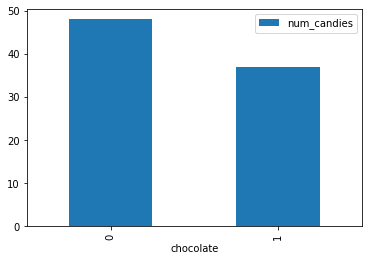

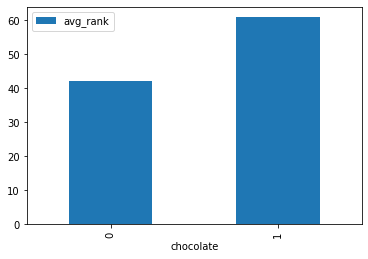

In [7]:
# Bar plot to see is_male with avg_wt linear and num_babies logarithmic
%matplotlib inline
df = get_distinct_values('chocolate')
df.plot(x='chocolate', y='num_candies', kind='bar');
df.plot(x='chocolate', y='avg_rank', kind='bar');

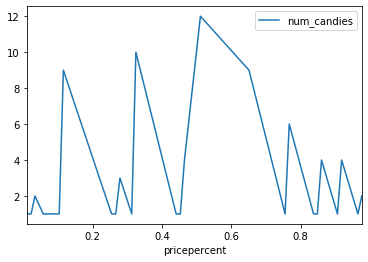

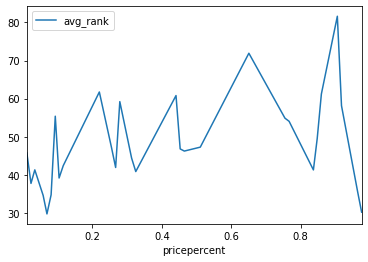

In [8]:
# Line plots to see mother_age with avg_wt linear and num_babies logarithmic
df = get_distinct_values('pricepercent')
df = df.sort_values('pricepercent')
df.plot(x='pricepercent', y='num_candies');
df.plot(x='pricepercent', y='avg_rank');

All these factors seem to play a part in the candy ranking. Chocolate is more popular on average. More expensive candies tend to be more popular. Preemies weigh in lower as do babies born to single moms. In addition, it is important to check whether you have enough data (number of candies) for each input value. Otherwise, the model prediction against input values that doesn't have enough data may not be reliable.

In the next section, I will develop a machine learning model to combine all of these factors to come up with a prediction of a candies ranking.

# 2. Create sampled dataset

Illustrates:

- Sampling a BigQuery dataset to create datasets for ML
- Preprocessing with Pandas

Let's sample the BigQuery data to create smaller datasets. 

In [9]:
# Create SQL query using candy_data
query = """
SELECT
    ABS(FARM_FINGERPRINT(competitorname)) AS hashname,
    chocolate, 
    fruity, 
    caramel, 
    peanutyalmondy, 
    nougat, 
    crispedricewafer, 
    hard, 
    bar, 
    pluribus, 
    sugarpercent, 
    pricepercent, 
    winpercent
FROM
  lidldatascientistadvanalytics.candy_data.original
"""

In [10]:
# Call BigQuery but GROUP BY the hashname and see number of records for each group to enable us to get the correct train and evaluation percentages
df = bigquery.Client().query("SELECT hashname, COUNT(winpercent) AS num_candies FROM (" + query + ") GROUP BY hashname ORDER BY num_candies").to_dataframe()
print("There are {} unique hashnames.".format(len(df)))
df.head()

There are 85 unique hashnames.


,hashname,num_candies
0,7046859833195853823,1
1,9167499499902123141,1
2,1631755363487315696,1
3,1606999616445289157,1
4,5825011382060312997,1


competitorname seems to be unique. Let's get a well distributed portion (half) of the data in such a way that the test and train sets do not overlap:

In [11]:
# Added the RAND() so that we can now subsample from each of the hashnames to get approximately the record counts we want
trainQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashname, 4) < 3 AND RAND() < 0.5"
evalQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashname, 4) = 3 AND RAND() < 0.5"
traindf = bigquery.Client().query(trainQuery).to_dataframe()
evaldf = bigquery.Client().query(evalQuery).to_dataframe()
print("There are {} examples in the train dataset and {} in the eval dataset".format(len(traindf), len(evaldf)))

There are 36 examples in the train dataset and 8 in the eval dataset


## Preprocess data using Pandas

In [12]:
traindf.head()


,hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,9167499499902123141,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
1,1631755363487315696,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
2,1606999616445289157,0,1,1,0,0,0,0,0,0,0.604,0.325,34.517681
3,7515611997518725754,0,1,0,0,0,0,1,0,0,0.046,0.104,39.141056
4,7524574358447315246,0,1,0,0,0,0,0,0,0,0.267,0.279,52.911392


Also notice that there may be some very important numeric fields that are missing in some rows (the count in Pandas doesn't count missing data)

In [13]:
# Let's look at a small sample of the training data
traindf.describe()

,hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
count,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,5.035438e+18,0.416667,0.472222,0.194444,0.194444,0.083333,0.027778,0.194444,0.194444,0.527778,0.453278,0.457222,49.842477
std,2.607820e+18,0.500000,0.506309,0.401386,0.401386,0.280306,0.166667,0.401386,0.401386,0.506309,0.300056,0.279452,15.423107
min,2.200173e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011000,0.058000,22.445341
25%,2.491026e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214250,0.264250,37.911778
50%,5.408639e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.447500,0.488000,51.344505
75%,7.099548e+18,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.636000,0.651000,59.393091
max,9.167499e+18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988000,0.976000,81.866257


It is always crucial to clean raw data before using in ML, so we have a preprocessing step. Our data are clean, but this is not general the case.

In [14]:
import pandas as pd
def preprocess(df):
  # clean up data we don't want to train on
  # in other words, users will have to tell us the mother's age
  # otherwise, our ML service won't work.
  # these were chosen because they are such good predictors
  # and because these are easy enough to collect
  df = df[df.sugarpercent > 0]
  df = df[df.pricepercent > 0]
  df = df[df.winpercent > 0]
  return df
traindf = preprocess(traindf)
evaldf = preprocess(evaldf)
# Describe only does numeric columns
traindf.describe()

,hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
count,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,5.035438e+18,0.416667,0.472222,0.194444,0.194444,0.083333,0.027778,0.194444,0.194444,0.527778,0.453278,0.457222,49.842477
std,2.607820e+18,0.500000,0.506309,0.401386,0.401386,0.280306,0.166667,0.401386,0.401386,0.506309,0.300056,0.279452,15.423107
min,2.200173e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011000,0.058000,22.445341
25%,2.491026e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214250,0.264250,37.911778
50%,5.408639e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.447500,0.488000,51.344505
75%,7.099548e+18,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.636000,0.651000,59.393091
max,9.167499e+18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988000,0.976000,81.866257


## Write out

In the final versions, we want to read from files, not Pandas dataframes. So, write the Pandas dataframes out as CSV files. Using CSV files gives us the advantage of shuffling during read. This is important for distributed training because some workers might be slower than others, and shuffling the data helps prevent the same data from being assigned to the slow workers.

In [15]:
traindf.to_csv('train.csv', index=False, header=False)
evaldf.to_csv('eval.csv', index=False, header=False)

In [16]:
%%bash
wc -l *.csv
head *.csv
tail *.csv

      86 candy-data.csv
       8 eval.csv
      36 train.csv
     130 total
==> candy-data.csv <==
competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
100 Grand,1,0,1,0,0,1,0,1,0,.73199999,.86000001,66.971725
3 Musketeers,1,0,0,0,1,0,0,1,0,.60399997,.51099998,67.602936
One dime,0,0,0,0,0,0,0,0,0,.011,.116,32.261086
One quarter,0,0,0,0,0,0,0,0,0,.011,.51099998,46.116505
Air Heads,0,1,0,0,0,0,0,0,0,.90600002,.51099998,52.341465
Almond Joy,1,0,0,1,0,0,0,1,0,.465,.76700002,50.347546
Baby Ruth,1,0,1,1,1,0,0,1,0,.60399997,.76700002,56.914547
Boston Baked Beans,0,0,0,1,0,0,0,0,1,.31299999,.51099998,23.417824
Candy Corn,0,0,0,0,0,0,0,0,1,.90600002,.32499999,38.010963

==> eval.csv <==
1149483840856303955,0,1,0,0,0,0,0,0,0,0.22,0.116,41.389557
3363714292214963851,0,0,1,0,0,0,1,0,0,0.186,0.26699999,41.904308
6285751633105298635,1,0,0,0,0,1,0,1,0,0.31299999,0.51099998,76.7686
9190403972146941111,1,0,1,1,0,1,0,1,0,0.

# 3. Develop a Tensorflow model

Illustrates:
- Creating a model using the high-level Estimator API

In [17]:
%%bash
ls *.csv

candy-data.csv
eval.csv
train.csv


## Create TensorFlow model using TensorFlow's Estimator API

First, write an input_fn to read the data.

In [18]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

1.14.0


In [19]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent'.split(',')
LABEL_COLUMN = 'winpercent'
KEY_COLUMN = 'hashname'

# Set default values for each CSV column
DEFAULTS = [['nokey'],[0], [0], [0], [0], [0], [0], [0], [0], [0],  [0.0], [0.0], [0.0]]
TRAIN_STEPS = 100

TensorFlow estimators work with input functions. The signature of an input function returns a tuple of features and labels. Features are a dictionary of feature names and numeric value arrays. Labels are an array of values. 

In [20]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size = 512):
  def _input_fn():
    def decode_csv(value_column):
      columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
      features = dict(zip(CSV_COLUMNS, columns))
      label = features.pop(LABEL_COLUMN)
      return features, label
    
    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename)

    # Create dataset from file list
    dataset = (tf.data.TextLineDataset(file_list)  # Read text file
                 .map(decode_csv))  # Transform each elem by applying decode_csv fn
      
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
        dataset = dataset.shuffle(buffer_size=10*batch_size)
    else:
        num_epochs = 1 # end-of-input after this
 
    dataset = dataset.repeat(num_epochs).batch(batch_size)
    return dataset
  return _input_fn

Next, define the feature columns

In [21]:
def get_cols():
  # Define column types
  return [\
          tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('chocolate', [0, 1])),
          tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('fruity', [0, 1])),
          #tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('caramel', [0, 1])),
          tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('peanutyalmondy', [0, 1])),
          #tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('nougat', [0, 1])),
          tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('crispedricewafer', [0, 1])),
          tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('hard', [0, 1])),
          tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('bar', [0, 1])),
          #tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('pluribus', [0, 1])),
          #tf.feature_column.numeric_column('sugarpercent'),
          tf.feature_column.numeric_column('pricepercent')
         ]

You need a serving input function if you want your model to be able to make predictions. The serving_input_fn specifies what the caller of the predict() method will have to provide. You are essentially telling the model what data it has to get from the user.

In [22]:
# Create serving input function to be able to serve predictions later using provided inputs
def serving_input_fn():
    feature_placeholders = {
        'chocolate': tf.placeholder(tf.int64, [None]),
        'fruity': tf.placeholder(tf.int64, [None]),
        #'caramel': tf.placeholder(tf.int64, [None]),
        'peanutyalmondy': tf.placeholder(tf.int64, [None]),
        #'nougat': tf.placeholder(tf.int64, [None]),
        'crispedricewafer': tf.placeholder(tf.int64, [None]),
        'hard': tf.placeholder(tf.int64, [None]),
        'bar': tf.placeholder(tf.int64, [None]),
        #'pluribus': tf.placeholder(tf.int64, [None]),
        #'sugarpercent': tf.placeholder(tf.float32, [None]),
        'pricepercent': tf.placeholder(tf.float32, [None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

Finally, train and evaluate!

In [23]:
# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
  EVAL_INTERVAL = 300
  run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                      keep_checkpoint_max = 3)
  estimator = tf.estimator.DNNRegressor(
                       model_dir = output_dir,
                       feature_columns = get_cols(),
                       hidden_units = [64, 32],
                       config = run_config)
  train_spec = tf.estimator.TrainSpec(
                       input_fn = read_dataset('train.csv', mode = tf.estimator.ModeKeys.TRAIN),
                       max_steps = TRAIN_STEPS)
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(
                       input_fn = read_dataset('eval.csv', mode = tf.estimator.ModeKeys.EVAL),
                       steps = None,
                       start_delay_secs = 60, # start evaluating after N seconds
                       throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
                       exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE" # see http://www.intel.com/software/products/support/.
    
# Run the model
shutil.rmtree('candy_trained', ignore_errors = True) # start fresh each time
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
train_and_evaluate('candy_trained')

W0907 11:01:22.483533 4670588352 deprecation.py:323] From /anaconda3/envs/gcstf/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0907 11:01:22.541843 4670588352 deprecation.py:506] From /anaconda3/envs/gcstf/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0907 11:01:22.908898 4670588352 deprecation.py:323] From /anaconda3/envs/gcstf/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2655: 

The exporter directory contains the final model.

In [24]:
%%bash
ls ./candy_trained/*

./candy_trained/checkpoint
./candy_trained/events.out.tfevents.1567846883.Trix.local
./candy_trained/graph.pbtxt
./candy_trained/model.ckpt-0.data-00000-of-00002
./candy_trained/model.ckpt-0.data-00001-of-00002
./candy_trained/model.ckpt-0.index
./candy_trained/model.ckpt-0.meta
./candy_trained/model.ckpt-100.data-00000-of-00002
./candy_trained/model.ckpt-100.data-00001-of-00002
./candy_trained/model.ckpt-100.index
./candy_trained/model.ckpt-100.meta

./candy_trained/eval:
events.out.tfevents.1567846891.Trix.local

./candy_trained/export:
exporter


### Monitor and experiment with training

To begin TensorBoard from within AI Platform Notebooks, click the + symbol in the top left corner and select the Tensorboard icon to create a new TensorBoard.
In TensorBoard, look at the learned embeddings. Are they getting clustered? How about the weights for the hidden layers? What if you run this longer? What happens if you change the batchsize?

In [25]:
import os
#loading the TensorBoard notebook extension
os.environ['TENSORBOARD_BINARY'] = "/anaconda3/envs/gcstf/bin/tensorboard"
os.environ['PATH'] = "/anaconda3/envs/gcstf/bin/:"+os.environ['PATH']
%load_ext tensorboard
%tensorboard --logdir {'candy_trained'}

Reusing TensorBoard on port 6006 (pid 2144), started 1:15:25 ago. (Use '!kill 2144' to kill it.)

## Create TensorFlow wide-and-deep model

Define the feature columns:

In [33]:
# Define feature columns
def get_wide_deep():
  # Define column types
  chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent = \
         [\
          tf.feature_column.categorical_column_with_vocabulary_list('chocolate', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('fruity', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('caramel', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('peanutyalmondy', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('nougat', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('crispedricewafer', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('hard', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('bar', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('pluribus', [0, 1]),
          tf.feature_column.numeric_column('sugarpercent'),
          tf.feature_column.numeric_column('pricepercent')
         ]

  # Discretize
  sugar_buckets = tf.feature_column.bucketized_column(sugarpercent, 
                      boundaries=np.arange(0.2,0.8,.2).tolist())
  price_buckets = tf.feature_column.bucketized_column(pricepercent, 
                      boundaries=np.arange(0.2,0.8,.2).tolist())

  # Sparse columns are wide, have a linear relationship with the output
  wide = [\
          chocolate,
          fruity,
          #caramel,
          peanutyalmondy,
          #nougat,
          crispedricewafer,
          hard,
          bar,
          #pluribus,
          #sugar_buckets,
          price_buckets
         ]

  # Feature cross all the wide columns and embed into a lower dimension
  crossed = tf.feature_column.crossed_column(wide, hash_bucket_size=20000)
  embed = tf.feature_column.embedding_column(crossed, 3)

  # Continuous columns are deep, have a complex relationship with the output
  deep = [\
          #sugarpercent,
          #pricepercent,
          embed]
  return wide, deep

Finally, train and evaluate!

In [34]:
# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
  wide, deep = get_wide_deep()
  EVAL_INTERVAL = 300
  run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                      keep_checkpoint_max = 3)
  estimator = tf.estimator.DNNLinearCombinedRegressor(
                       model_dir = output_dir,
                       linear_feature_columns = wide,
                       dnn_feature_columns = deep,
                       dnn_hidden_units = [64, 32],
                       config = run_config)
  train_spec = tf.estimator.TrainSpec(
                       input_fn = read_dataset('train.csv', mode = tf.estimator.ModeKeys.TRAIN),
                       max_steps = TRAIN_STEPS)
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(
                       input_fn = read_dataset('eval.csv', mode = tf.estimator.ModeKeys.EVAL),
                       steps = None,
                       start_delay_secs = 60, # start evaluating after N seconds
                       throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
                       exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    
# Run the model
shutil.rmtree('candy_trained', ignore_errors = True) # start fresh each time
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
train_and_evaluate('candy_trained')

W0907 11:03:54.124727 4670588352 export_utils.py:182] Export includes no default signature!


The exporter directory contains the final model.

In [28]:
%%bash
ls ./candy_trained/*

./candy_trained/checkpoint
./candy_trained/events.out.tfevents.1567846883.Trix.local
./candy_trained/graph.pbtxt
./candy_trained/model.ckpt-0.data-00000-of-00002
./candy_trained/model.ckpt-0.data-00001-of-00002
./candy_trained/model.ckpt-0.index
./candy_trained/model.ckpt-0.meta
./candy_trained/model.ckpt-100.data-00000-of-00002
./candy_trained/model.ckpt-100.data-00001-of-00002
./candy_trained/model.ckpt-100.index
./candy_trained/model.ckpt-100.meta

./candy_trained/eval:
events.out.tfevents.1567846891.Trix.local

./candy_trained/export:
exporter


### Monitor and experiment with training

To begin TensorBoard from within AI Platform Notebooks, click the + symbol in the top left corner and select the Tensorboard icon to create a new TensorBoard.
In TensorBoard, look at the learned embeddings. Are they getting clustered? How about the weights for the hidden layers? What if you run this longer? What happens if you change the batchsize?

In [29]:
#loading the TensorBoard notebook extension
#%load_ext tensorboard.notebook
%tensorboard --logdir {'candy_trained'}

Reusing TensorBoard on port 6006 (pid 2144), started 1:15:37 ago. (Use '!kill 2144' to kill it.)

# 4. Create training and evaluation dataset
Illustrates:
- Creating datasets for Machine Learning using Dataflow

While Pandas is fine for experimenting, for operationalization of your workflow, it is better to do preprocessing in Apache Beam. This will also help if you need to preprocess data in flight, since Apache Beam also allows for streaming.

Make sure the Dataflow API is enabled by going to [this link](https://console.developers.google.com/apis/api/dataflow.googleapis.com). Ensure that you've installed Beam by importing it and printing the version number.

In [76]:
import apache_beam as beam
print(beam.__version__) # 2.13.0 recomended

2.15.0


You may receive a UserWarning about the Apache Beam SDK for Python 3 as not being yet fully supported. Don't worry about this.

Make sure you still have your query:

In [77]:
# Create SQL query using candy_data
query = """
SELECT
    ABS(FARM_FINGERPRINT(competitorname)) AS hashname,
    chocolate, 
    fruity, 
    caramel, 
    peanutyalmondy, 
    nougat, 
    crispedricewafer, 
    hard, 
    bar, 
    pluribus, 
    sugarpercent, 
    pricepercent, 
    winpercent
FROM
  lidldatascientistadvanalytics.candy_data.original
"""
# Call BigQuery and examine in dataframe
from google.cloud import bigquery
df = bigquery.Client().query(query + " LIMIT 100").to_dataframe()
df.head()

,hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,7046859833195853823,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
1,9167499499902123141,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
2,1631755363487315696,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
3,1606999616445289157,0,1,1,0,0,0,0,0,0,0.604,0.325,34.517681
4,5825011382060312997,0,1,0,0,0,0,1,0,0,0.732,0.034,39.460556


## Create ML dataset using Dataflow

Let's use Cloud Dataflow to read in the BigQuery data, do some preprocessing, and write it out as CSV files.

Instead of using Beam/Dataflow, we have three other options:
- Use Cloud Dataprep to visually author a Dataflow pipeline. Cloud Dataprep also allows me to explore the data, so we could have avoided much of the handcoding of Python/Seaborn calls above as well!
- Read from BigQuery directly using TensorFlow.
- Use the BigQuery console (http://bigquery.cloud.google.com) to run a Query and save the result as a CSV file. For larger datasets, you may have to select the option to "allow large results" and save the result into a CSV file on Google Cloud Storage.

However, in this case, we want to do some preprocessing. If we didn't need preprocessing, we could have used the web console. Also, I prefer to script it out rather than run queries on the user interface, so I am using Cloud Dataflow for the preprocessing.

Note that after you launch this, the actual processing is happening on the cloud. Go to the GCP webconsole to the Dataflow section and monitor the running job.

In [78]:
import datetime, os

def to_csv(rowdict):
  # Pull columns from BQ and create a line
  import hashlib
  import copy
  CSV_COLUMNS = 'hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent'.split(',')
  # TODO preprocessing if needed
    
  # Write out two rows for each input row, one with ultrasound and one without
  for result in [rowdict]:
    data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
    yield str('{}'.format(data))
  
def preprocess(in_test_mode):
  import shutil, os, subprocess
  job_name = 'preprocess-candy-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')

  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './preproc'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/candy/preproc/'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass

  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'region': REGION,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True,
      'max_num_workers': 6
  }
  #The PipelineOptions() method is a command line parser that will 
  #read any standard option passed the following way --<option>=<value>
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  p = beam.Pipeline(RUNNER, options = opts)
  query = """
SELECT
    ABS(FARM_FINGERPRINT(competitorname)) AS hashname,
    chocolate, 
    fruity, 
    caramel, 
    peanutyalmondy, 
    nougat, 
    crispedricewafer, 
    hard, 
    bar, 
    pluribus, 
    sugarpercent, 
    pricepercent, 
    winpercent
FROM
  lidldatascientistadvanalytics.candy_data.original
    """

  if in_test_mode:
    query = query + ' LIMIT 100' 

  for step in ['train', 'eval']:
    if step == 'train':
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashname),4) < 3'.format(query)
    else:
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashname),4) = 3'.format(query)

    (p 
     | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query = selquery, use_standard_sql = True))
     | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
     | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
    )

  job = p.run()
  if in_test_mode:
    job.wait_until_finish()
    print("Done!")
    
preprocess(in_test_mode = False)

Launching Dataflow job preprocess-candy-features-190907-183519 ... hang on


if you look closely the code first we do the preprocessing required than we write a dataflow pipeline that reads csv files from bigquery and writes to cloud storage as textfile.

The above step will take some time. Go to the GCP web console, navigate to the Dataflow section and wait for the job to finish before you run the following step.

In [49]:
%%bash
gsutil ls gs://${BUCKET}/candy/preproc/*-00000*

gs://lidldatascientistadvanalytics/candy/preproc/eval.csv-00000-of-00001
gs://lidldatascientistadvanalytics/candy/preproc/train.csv-00000-of-00001


# 5. Execute training
Illustrates: 
- distributed training and 
- hyperparameter tuning on Cloud AI Platform

In [50]:
os.environ['TFVERSION'] = '1.13'

In [52]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION
gsutil ls gs://${BUCKET}/candy/preproc/*-00000*

gs://lidldatascientistadvanalytics/candy/preproc/eval.csv-00000-of-00001
gs://lidldatascientistadvanalytics/candy/preproc/train.csv-00000-of-00001


Updated property [core/project].
Updated property [compute/region].


Now that we have the TensorFlow code working on a subset of the data, we can package the TensorFlow code up as a Python module and train it on Cloud AI Platform.

## Train on Cloud AI Platform

Training on Cloud AI Platform requires:

- Making the code a Python package
- Using gcloud to submit the training code to Cloud AI Platform

Ensure that the AI Platform API is enabled by going to this [link](https://console.developers.google.com/apis/library/ml.googleapis.com).

### create python package 

The following code edits candy/trainer/task.py.

In [56]:
%%writefile candy/trainer/task.py
import argparse
import json
import os

from . import model

import tensorflow as tf

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--bucket',
        help = 'GCS path to data. We assume that data is in gs://BUCKET/babyweight/preproc/',
        required = True
    )
    parser.add_argument(
        '--output_dir',
        help = 'GCS location to write checkpoints and export models',
        required = True
    )
    parser.add_argument(
        '--batch_size',
        help = 'Number of examples to compute gradient over.',
        type = int,
        default = 512
    )
    parser.add_argument(
        '--job-dir',
        help = 'this model ignores this field, but it is required by gcloud',
        default = 'junk'
    )
    parser.add_argument(
        '--nnsize',
        help = 'Hidden layer sizes to use for DNN feature columns -- provide space-separated layers',
        nargs = '+',
        type = int,
        default=[128, 32, 4]
    )
    parser.add_argument(
        '--nembeds',
        help = 'Embedding size of a cross of n key real-valued parameters',
        type = int,
        default = 3
    )

    ## TODO 1: add the new arguments here 
    parser.add_argument(
        '--train_examples',
        help = 'Number of examples (in thousands) to run the training job over. If this is more than actual # of examples available, it cycles through them. So specifying 1000 here when you have only 100k examples makes this 10 epochs.',
        type = int,
        default = 5000
    )    
    parser.add_argument(
        '--pattern',
        help = 'Specify a pattern that has to be in input files. For example 00001-of will process only one shard',
        default = 'of'
    )
    parser.add_argument(
        '--eval_steps',
        help = 'Positive number of steps for which to evaluate model. Default to None, which means to evaluate until input_fn raises an end-of-input exception',
        type = int,       
        default = None
    )
        
    ## parse all arguments
    args = parser.parse_args()
    arguments = args.__dict__

    # unused args provided by service
    arguments.pop('job_dir', None)
    arguments.pop('job-dir', None)

    ## assign the arguments to the model variables
    output_dir = arguments.pop('output_dir')
    model.BUCKET     = arguments.pop('bucket')
    model.BATCH_SIZE = arguments.pop('batch_size')
    model.TRAIN_STEPS = (arguments.pop('train_examples') * 1000) / model.BATCH_SIZE
    model.EVAL_STEPS = arguments.pop('eval_steps')    
    print ("Will train for {} steps using batch_size={}".format(model.TRAIN_STEPS, model.BATCH_SIZE))
    model.PATTERN = arguments.pop('pattern')
    model.NEMBEDS= arguments.pop('nembeds')
    model.NNSIZE = arguments.pop('nnsize')
    print ("Will use DNN size of {}".format(model.NNSIZE))

    # Append trial_id to path if we are doing hptuning
    # This code can be removed if you are not using hyperparameter tuning
    output_dir = os.path.join(
        output_dir,
        json.loads(
            os.environ.get('TF_CONFIG', '{}')
        ).get('task', {}).get('trial', '')
    )

    # Run the training job
    model.train_and_evaluate(output_dir)

Overwriting candy/trainer/task.py


The following code edits candy/trainer/model.py.

In [85]:
%%writefile candy/trainer/model.py
import shutil
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

BUCKET = None  # set from task.py
PATTERN = 'of' # gets all files

# Determine CSV, label, and key columns
CSV_COLUMNS = 'hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent'.split(',')
LABEL_COLUMN = 'winpercent'
KEY_COLUMN = 'hashname'

# Set default values for each CSV column
DEFAULTS = [['nokey'],[0], [0], [0], [0], [0], [0], [0], [0], [0],  [0.0], [0.0], [0.0]]

# Define some hyperparameters
TRAIN_STEPS = 10000
EVAL_STEPS = None
BATCH_SIZE = 512
NEMBEDS = 3
NNSIZE = [64, 16, 4]

# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(prefix, mode, batch_size):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL_COLUMN)
            return features, label
        
        # Use prefix to create file path
        file_path = 'gs://{}/candy/preproc/{}*{}*'.format(BUCKET, prefix, PATTERN)

        # Create list of files that match pattern
        file_list = tf.gfile.Glob(file_path)

        # Create dataset from file list
        dataset = (tf.data.TextLineDataset(file_list)  # Read text file
                    .map(decode_csv))  # Transform each elem by applying decode_csv fn
      
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)
        else:
            num_epochs = 1 # end-of-input after this
 
        dataset = dataset.repeat(num_epochs).batch(batch_size)
        return dataset.make_one_shot_iterator().get_next() #?
    return _input_fn

# Define feature columns
def get_wide_deep():
    # Define column types
  chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent = \
         [\
          tf.feature_column.categorical_column_with_vocabulary_list('chocolate', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('fruity', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('caramel', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('peanutyalmondy', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('nougat', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('crispedricewafer', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('hard', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('bar', [0, 1]),
          tf.feature_column.categorical_column_with_vocabulary_list('pluribus', [0, 1]),
          tf.feature_column.numeric_column('sugarpercent'),
          tf.feature_column.numeric_column('pricepercent')
         ]

  # Discretize
  sugar_buckets = tf.feature_column.bucketized_column(sugarpercent, 
                      boundaries=np.arange(0.2,0.8,.2).tolist())
  price_buckets = tf.feature_column.bucketized_column(pricepercent, 
                      boundaries=np.arange(0.2,0.8,.2).tolist())

  # Sparse columns are wide, have a linear relationship with the output
  wide = [\
          chocolate,
          fruity,
          #caramel,
          peanutyalmondy,
          #nougat,
          crispedricewafer,
          hard,
          bar,
          #pluribus,
          #sugar_buckets,
          price_buckets
         ]

  # Feature cross all the wide columns and embed into a lower dimension
  crossed = tf.feature_column.crossed_column(wide, hash_bucket_size=20000)
  embed = tf.feature_column.embedding_column(crossed, 3)

  # Continuous columns are deep, have a complex relationship with the output
  deep = [\
          #sugarpercent,
          #pricepercent,
          embed]
  return wide, deep

# Create serving input function to be able to serve predictions later using provided inputs
def serving_input_fn():
    feature_placeholders = {
        KEY_COLUMN: tf.placeholder_with_default(tf.constant(['nokey']), [None]),
        'chocolate': tf.placeholder(tf.int64, [None]),
        'fruity': tf.placeholder(tf.int64, [None]),
        #'caramel': tf.placeholder(tf.int64, [None]),
        'peanutyalmondy': tf.placeholder(tf.int64, [None]),
        #'nougat': tf.placeholder(tf.int64, [None]),
        'crispedricewafer': tf.placeholder(tf.int64, [None]),
        'hard': tf.placeholder(tf.int64, [None]),
        'bar': tf.placeholder(tf.int64, [None]),
        #'pluribus': tf.placeholder(tf.int64, [None]),
        #'sugarpercent': tf.placeholder(tf.float32, [None]),
        'pricepercent': tf.placeholder(tf.float32, [None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

# create metric for hyperparameter tuning
def my_rmse(labels, predictions):
    pred_values = predictions['predictions']
    return {'rmse': tf.metrics.root_mean_squared_error(labels, pred_values)}

# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
    tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
    wide, deep = get_wide_deep()
    EVAL_INTERVAL = 300 # seconds

    run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                        keep_checkpoint_max = 3)
    
    estimator = tf.estimator.DNNLinearCombinedRegressor(
        model_dir = output_dir,
        linear_feature_columns = wide,
        dnn_feature_columns = deep,
        dnn_hidden_units = NNSIZE,
        config = run_config)
    
    # illustrates how to add an extra metric
    estimator = tf.contrib.estimator.add_metrics(estimator, my_rmse)
    # for batch prediction, you need a key associated with each instance
    estimator = tf.contrib.estimator.forward_features(estimator, KEY_COLUMN)
    
    train_spec = tf.estimator.TrainSpec(
        input_fn = read_dataset('train', tf.estimator.ModeKeys.TRAIN, BATCH_SIZE),
        max_steps = TRAIN_STEPS)
    
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn, exports_to_keep=None)

    eval_spec = tf.estimator.EvalSpec(
        input_fn = read_dataset('eval', tf.estimator.ModeKeys.EVAL, 2**15),  # no need to batch in eval
        steps = EVAL_STEPS,
        start_delay_secs = 60, # start evaluating after N seconds
        throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
        exporters = exporter)
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Overwriting candy/trainer/model.py


In [95]:
%%writefile candy/trainer/__init__.py
# Copyright 2019 Olaf Bochmann. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================


Writing candy/trainer/__init__.py


### test python package

After moving the code to a package, make sure it works standalone. (Note the --pattern and --train_examples lines so that I am not trying to boil the ocean on my laptop). Even then, this takes about 3 minutes in which you won't see any output ...

In [86]:
%%bash
. /anaconda3/etc/profile.d/conda.sh
conda activate
conda activate gcstf
echo "path=${PATH}"
echo "bucket=${BUCKET}"
rm -rf candy_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/candy
python -m trainer.task \
  --bucket=${BUCKET} \
  --output_dir=candy_trained \
  --job-dir=./tmp \
  --pattern="00000-of-" --train_examples=1 --eval_steps=1
conda deactivate

path=/anaconda3/gcstf/bin:/anaconda3/envs/gcstf/bin:/anaconda3/bin:/anaconda3/bin:/anaconda3/condabin:/Users/bochmann/google-cloud-sdk/bin:/opt/local/bin/ruby2.5:/Applications/calibre.app/Contents/MacOS:/Users/bochmann/bin:/opt/local/bin:/opt/local/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/opt/X11/bin
bucket=lidldatascientistadvanalytics
Will train for 1.953125 steps using batch_size=512
Will use DNN size of [128, 32, 4]





INFO:tensorflow:Using config: {'_model_dir': 'candy_trained/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 300, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x6397b29e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflo

The exporter directory contains the test model.

In [87]:
%%bash
ls ./candy_trained/*

./candy_trained/checkpoint
./candy_trained/events.out.tfevents.1567876004.Trix.local
./candy_trained/graph.pbtxt
./candy_trained/model.ckpt-0.data-00000-of-00002
./candy_trained/model.ckpt-0.data-00001-of-00002
./candy_trained/model.ckpt-0.index
./candy_trained/model.ckpt-0.meta
./candy_trained/model.ckpt-2.data-00000-of-00002
./candy_trained/model.ckpt-2.data-00001-of-00002
./candy_trained/model.ckpt-2.index
./candy_trained/model.ckpt-2.meta

./candy_trained/eval:
events.out.tfevents.1567876020.Trix.local

./candy_trained/export:
exporter


The JSON below represents an input into your prediction model. Write the input.json file below with the next cell, then run the prediction locally to assess whether it produces predictions correctly.

In [128]:
%%writefile inputs.json
{"hashname": 1, "chocolate": 1, "fruity": 1, "peanutyalmondy": 1, "crispedricewafer": 1, "hard": 1, "bar": 1, "pricepercent": 0.1}
{"hashname": 2, "chocolate": 1, "fruity": 1, "peanutyalmondy": 1, "crispedricewafer": 1, "hard": 1, "bar": 1, "pricepercent": 0.8}

Overwriting inputs.json


In [130]:
%%bash
MODEL_LOCATION=$(ls -d $(pwd)/candy_trained/export/exporter/* | tail -1)
echo $MODEL_LOCATION
#gcloud ai-platform local predict --model-dir=$MODEL_LOCATION --json-instances=inputs.json

/Users/bochmann/Projects/candy-power-ranking/candy_trained/export/exporter/1567876020


## run it on Cloud AI Platform

Once the code works in standalone mode, you can run it on Cloud AI Platform. Because this is on the entire dataset, it will take a while. The training run took about two hours for me. You can monitor the job from the GCP console in the Cloud AI Platform section.

In [96]:
%%bash
OUTDIR=gs://${BUCKET}/candy/trained_model
JOBNAME=candy_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/candy/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=$TFVERSION \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --train_examples=200000

gs://lidldatascientistadvanalytics/candy/trained_model us-central1 candy_190907_172418
jobId: candy_190907_172418
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [candy_190907_172418] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe candy_190907_172418

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs candy_190907_172418


When I ran it, I used train_examples=2000000. When training finished, I filtered in the Stackdriver log on the word "dict" and saw that the last line was:

"Saving dict for global step 390633: average_loss = 264.32812, global_step = 390633, label/mean = 47.618057, loss = 4757.9062, prediction/mean = 45.579086, rmse = 16.258171"    

## Hyperparameter tuning

All of these are command-line parameters to my program. To do hyperparameter tuning, create hyperparam.xml and pass it as --configFile. This step will take up to 2 hours -- you can increase maxParallelTrials or reduce maxTrials to get it done faster. Since maxParallelTrials is the number of initial seeds to start searching from, you don't want it to be too large; otherwise, all you have is a random search.

In [97]:
%%writefile hyperparam.yaml
trainingInput:
  scaleTier: STANDARD_1
  hyperparameters:
    hyperparameterMetricTag: rmse
    goal: MINIMIZE
    maxTrials: 20
    maxParallelTrials: 5
    enableTrialEarlyStopping: True
    params:
    - parameterName: batch_size
      type: INTEGER
      minValue: 8
      maxValue: 512
      scaleType: UNIT_LOG_SCALE
    - parameterName: nembeds
      type: INTEGER
      minValue: 3
      maxValue: 30
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: nnsize
      type: INTEGER
      minValue: 64
      maxValue: 512
      scaleType: UNIT_LOG_SCALE

Writing hyperparam.yaml


In [98]:
%%bash
OUTDIR=gs://${BUCKET}/candy/hyperparam
JOBNAME=candy_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/candy/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --config=hyperparam.yaml \
  --runtime-version=$TFVERSION \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --eval_steps=10 \
  --train_examples=20000

gs://lidldatascientistadvanalytics/candy/hyperparam us-central1 candy_190907_190746
jobId: candy_190907_190746
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [candy_190907_190746] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe candy_190907_190746

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs candy_190907_190746


### Repeat training
This time with tuned parameters (note last line)

In [100]:
%%bash
OUTDIR=gs://${BUCKET}/candy/trained_model_tuned
JOBNAME=candy_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/candy/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=$TFVERSION \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --train_examples=20000 --batch_size=8 --nembeds=30 --nnsize=502

gs://lidldatascientistadvanalytics/candy/trained_model_tuned us-central1 candy_190908_033401
jobId: candy_190908_033401
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [candy_190908_033401] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe candy_190908_033401

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs candy_190908_033401


"Saving dict for global step 2500007: average_loss = 242.73277, global_step = 2500007, label/mean = 47.618057, loss = 4369.19, prediction/mean = 44.26384, rmse = 15.579884"    

In [103]:
os.environ['PATH'] = "/anaconda3/envs/gcstf/bin/:"+os.environ['PATH']
%load_ext tensorboard
%tensorboard --logdir {os.path.join(BUCKET, '/candy/trained_model_tuned')}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 6. Deploy prediction service

Illustrates:
- Deploying model
- Predicting with model

## Deploy trained model
Deploying the trained model to act as a REST web service is a simple gcloud call.

In [104]:
%%bash
gsutil ls gs://${BUCKET}/candy/trained_model_tuned/export/exporter/

gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567914313/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567914613/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567915212/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567915513/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567916124/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567916717/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567917023/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567917613/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567918213/
gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567918366/


In [105]:
%%bash
MODEL_NAME="candy"
MODEL_VERSION="ml_on_gcp"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/candy/trained_model_tuned/export/exporter/ | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ai-platform models delete ${MODEL_NAME}
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

Deleting and deploying candy ml_on_gcp from gs://lidldatascientistadvanalytics/candy/trained_model_tuned/export/exporter/1567918366/ ... this will take a few minutes


Created ml engine model [projects/lidldatascientistadvanalytics/models/candy].
Creating version (this might take a few minutes)......
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Use model to predict (online prediction)
Send a JSON request to the endpoint of the service to make it predict a baby's weight. The order of the responses are the order of the instances.

In [144]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)

request_data = {'instances':
  [
      {
          "hashname": "1", 
          "chocolate": 1, 
          "fruity": 1, 
          "peanutyalmondy": 1, 
          "crispedricewafer": 1, 
          "hard": 1, 
          "bar": 1, 
          "pricepercent": 0.1
      },
      {
          "hashname": "2", 
          "chocolate": 0, 
          "fruity": 1, 
          "peanutyalmondy": 0, 
          "crispedricewafer": 1, 
          "hard": 1, 
          "bar": 1, 
          "pricepercent": 0.5
      },
      {
          "hashname": "3", 
          "chocolate": 1, 
          "fruity": 1, 
          "peanutyalmondy": 1, 
          "crispedricewafer": 1, 
          "hard": 1, 
          "bar": 0, 
          "pricepercent": 0.8
      }
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, MODEL_NAME, MODEL_VERSION)
response = api.projects().predict(body=request_data, name=parent).execute()
print(json.dumps(response, sort_keys = True, indent = 4))

{
    "predictions": [
        {
            "hashname": [
                "1"
            ],
            "predictions": [
                28.833826065063477
            ]
        },
        {
            "hashname": [
                "2"
            ],
            "predictions": [
                18.41912078857422
            ]
        },
        {
            "hashname": [
                "3"
            ],
            "predictions": [
                50.689414978027344
            ]
        }
    ]
}


The predictions for the three instances were: 29, 18 and 50 pounds respectively when I ran it (your results might be different).

## Use model to predict (batch prediction)
Batch prediction is commonly used when you thousands to millions of predictions. Create a file with one instance per line and submit using gcloud.

In [135]:
%%bash
gsutil cat gs://${BUCKET}/candy/batchpred/inputs.json

{"hashname": 1, "chocolate": 1, "fruity": 1, "peanutyalmondy": 1, "crispedricewafer": 1, "hard": 1, "bar": 1, "pricepercent": 0.1}
{"hashname": 2, "chocolate": 1, "fruity": 1, "peanutyalmondy": 1, "crispedricewafer": 1, "hard": 1, "bar": 1, "pricepercent": 0.8}


In [136]:
%%bash
INPUT=gs://${BUCKET}/candy/batchpred/inputs.json
OUTPUT=gs://${BUCKET}/candy/batchpred/outputs
gsutil cp inputs.json $INPUT
gsutil -m rm -rf $OUTPUT 
gcloud ai-platform jobs submit prediction candypred_$(date -u +%y%m%d_%H%M%S) \
  --data-format=TEXT --region ${REGION} \
  --input-paths=$INPUT \
  --output-path=$OUTPUT \
  --model=candy --version=ml_on_gcp

jobId: candypred_190909_102514
state: QUEUED


Copying file://inputs.json [Content-Type=application/json]...
-
Operation completed over 1 objects/262.0 B.                                      
Removing gs://lidldatascientistadvanalytics/candy/batchpred/outputs/prediction.errors_stats-00000-of-00001#1568024406459649...
Removing gs://lidldatascientistadvanalytics/candy/batchpred/outputs/prediction.results-00000-of-00001#1568024384053711...
/ [2/2 objects] 100% Done                                                       
Operation completed over 2 objects.                                              
Job [candypred_190909_102514] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe candypred_190909_102514

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs candypred_190909_102514


In [145]:
%%bash
gsutil cat gs://${BUCKET}/candy/batchpred/outputs/prediction.*

('Exception during running the graph: Unable to get element as bytes.', 1)


# 7. Automate

see details at https://github.com/OleBo/candy-power-ranking/tree/master/pipeline

# 8. Invoke ML prediction

see details at https://github.com/OleBo/candy-power-ranking/tree/master/application